In [260]:
import pandas as pd
import numpy as np
import os 
os.chdir(r'F:\社区发现算法实现\社区发现demo')

## 导入原始数据
1、data_id为客户ID数据  （为data_edges里 source 和 target的集合）  
2、data_edges为边数据，可以为交易数据

In [261]:
data_edges=pd.read_csv(r'input_data\data_edges.csv')
data_edges.head()

,Source,Target,Type,Id,Label,timeset,Weight
0,2,1,Undirected,0,NaN,NaN,1
1,3,1,Undirected,1,NaN,NaN,1
2,3,2,Undirected,2,NaN,NaN,1
3,4,1,Undirected,3,NaN,NaN,1
4,4,2,Undirected,4,NaN,NaN,1


In [284]:
### data_id 为data_edges里 source 和 target的集合
data_id=pd.read_csv(r'input_data\data_id.csv')
data_id=data_id.drop_duplicates()
data_id.head()

,Id,Label
0,1,a
1,2,b
2,3,c
3,4,d
4,5,e


## 构建gml格式数据文件

### 将数据转换为邻接矩阵

In [263]:
data_edges_jz=data_edges[['Source','Target','Weight']].groupby(['Source','Target']).count().unstack().fillna('0')['Weight']

In [264]:
data_edges_jz.head()

Target,1,2,3,4,5,6,7,9,10,14,...,24,25,26,27,28,29,30,31,32,33
Source,,,,,,,,,,,,,,,,,,,,,
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [265]:
data_edges_jz.columns

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 14, 15, 16, 19, 20, 21, 23, 24,
            25, 26, 27, 28, 29, 30, 31, 32, 33],
           dtype='int64', name='Target')

In [266]:
data_edges_jz.index

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 18, 20, 22,
            26, 28, 29, 30, 31, 32, 33, 34],
           dtype='int64', name='Source')

### 生成gml

In [269]:
with open(r'output_data\data.gml','w') as fp_out:
    fp_out.write("graph [\n")
    for node,label in zip(data_id['Id'],data_id['Label']):
        fp_out.write("\tnode [\n")
        fp_out.write("\t\tid "+str(node)+"\n")
        fp_out.write("\t\tlabel \""+str(label)+"\"\n")
        # insert other node attributes here
        fp_out.write("\t]\n")
    for node1 in data_edges_jz.index:
        for node2 in data_edges_jz.columns:
            if data_edges_jz.loc[node1,node2]!='0':
                fp_out.write("\tedge [\n")
                fp_out.write("\t\tsource "+str(node1)+"\n")
                fp_out.write("\t\ttarget "+str(node2)+"\n")
                fp_out.write("\t\tvalue "+str(data_edges_jz.loc[node1,node2])+"\n")
                # insert other edge attributes here
                fp_out.write("\t]\n")
    fp_out.write("]\t")

### 读入数据作图（ 测试gml数据是否可用 ）

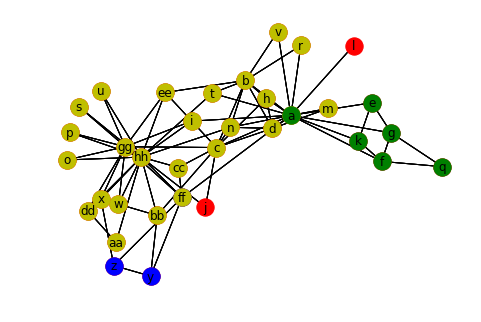

In [271]:
import networkx as nx 
import matplotlib.pyplot as plt 
from networkx.algorithms.community import k_clique_communities
G = nx.read_gml("output_data\data.gml")
klist = list(k_clique_communities(G,3)) #list of k-cliques in the network. each element contains the nodes that consist the clique.

#plotting
pos = nx.spring_layout(G)
plt.clf()
nx.draw(G,pos = pos, with_labels=True)
nx.draw(G,pos = pos, nodelist = klist[0], node_color = 'b')
nx.draw(G,pos = pos, nodelist = klist[1], node_color = 'y')
nx.draw(G,pos = pos, nodelist = klist[2], node_color = 'g')
plt.show()

### 构建模型 G-N模型

In [300]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

class GN_w:
    def __init__(self, G):
        self.G_copy = G.copy()
        self.G = G
        self.partition = [[n for n in G.nodes()]]
        self.all_Q = [0.0]
        self.max_Q = 0.0
    #Using max_Q to divide communities 
    def run(self):
        while len(self.G.edges()) != 0:
            edges={}
            edges_betweenness_centrality = nx.edge_betweenness_centrality(self.G)            
            for e, ebc in edges_betweenness_centrality.items():
                edge_weight = ebc/self.G.get_edge_data(e[0],e[1])['value']
                edges[e]=edge_weight               
            edge = max(edges.items(), key=lambda item:item[1])[0]
            self.G.remove_edge(edge[0], edge[1])
            components = [list(c) for c in list(nx.connected_components(self.G))]
            if len(components) != len(self.partition):
                #compute the Q
                cur_Q = self.cal_Q(components, self.G_copy)
                if cur_Q not in self.all_Q:
                    self.all_Q.append(cur_Q)
                if cur_Q > self.max_Q:
                    self.max_Q = cur_Q
                    self.partition = components
                    
        print('-----------the Max Q and divided communities-----------')
        print('The number of Communites:', len(self.partition))
        print("Communites:", self.partition)
        print('Max_Q:', self.max_Q)
        return self.partition, self.all_Q, self.max_Q
        
        
    #the process of divding the network
    #Return a list containing the result of each division, until each node is a community
    def run_to_all(self):
        divide = []
        all_Q = []
        while len(self.G.edges()) != 0:
            edge = max(nx.edge_betweenness_centrality(self.G).items(),key=lambda item:item[1])[0]
            self.G.remove_edge(edge[0], edge[1])
            components = [list(c) for c in list(nx.connected_components(self.G))]
            if components not in divide:
                divide.append(components)
            cur_Q = self.cal_Q(components, self.G_copy)
            if cur_Q not in all_Q:
                all_Q.append(cur_Q)
        return divide, all_Q
       
#Drawing the graph of Q and divided communities
    def draw_Q(self):
        plt.plot([x for x in range(1,len(self.G.nodes)+1)],self.all_Q)
        my_x_ticks = [x for x in range(1,len(self.G.nodes)+1)]
        plt.xticks(my_x_ticks)
        plt.axvline(len(self.partition),color='black',linestyle="--")
        #plt.axhline(self.all_Q[3],color='red',linestyle="--")
        plt.show()
    
    def add_group(self):
        global nodegroup
        num = 0
        nodegroup = {}
        for partition in self.partition:
            for node in partition:
                nodegroup[node] = {'group':num}
        nx.set_node_attributes(self.G_copy, nodegroup)
        
    def to_gml(self):
        nx.write_gml(self.G_copy, 'output_data\outputofGN_weighted.gml')
    
#Computing the Q
    def cal_Q(self,partition,G):
        m = len(G.edges(None, False))
        a = []
        e = []    
        for community in partition:
            t = 0.0
            for node in community:
                t += len([x for x in G.neighbors(node)])
            a.append(t/(2*m))        
        for community in partition:
            t = 0.0
            for i in range(len(community)):
                for j in range(len(community)):
                    if(G.has_edge(community[i], community[j])):
                        t += 1.0
            e.append(t/(2*m))        
        q = 0.0
        for ei,ai in zip(e,a):
            q += (ei - ai**2) 
        return q 

-----------the Max Q and divided communities-----------
The number of Communites: 5
Communites: [['d', 'b', 'l', 't', 'h', 'm', 'n', 'r', 'v', 'a'], ['z', 'cc', 'c', 'y', 'ff', 'bb'], ['f', 'e', 'k', 'q', 'g'], ['ee', 'x', 'i', 'p', 'u', 'o', 's', 'aa', 'hh', 'gg', 'dd', 'w'], ['j']]
Max_Q: 0.40129848783694944


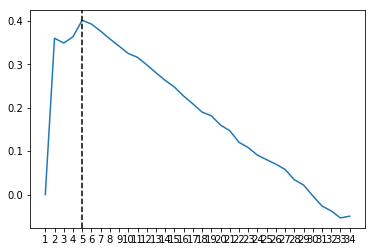

In [301]:
if __name__ == '__main__':
    G=nx.read_gml('output_data\data.gml')    
    algorithm = GN_w(G)
    algorithm.run()
    algorithm.add_group()
    algorithm.draw_Q()
    algorithm.to_gml()

### 分群可视化

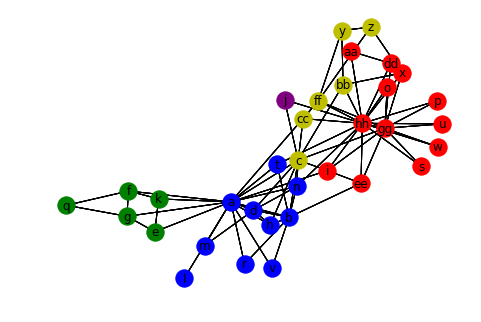

In [275]:
G = nx.read_gml("output_data\outputofGN_weighted.gml")
# klist = list(k_clique_communities(G,3)) #list of k-cliques in the network. each element contains the nodes that consist the clique.

#plotting
pos = nx.spring_layout(G)
plt.clf()
# nx.draw(G,pos = pos, with_labels=True,node_color=node_color)
nx.draw(G,pos = pos, nodelist = frozenset([str(i) for i in algorithm.partition[0]]), node_color = 'b',with_labels=True)
nx.draw(G,pos = pos, nodelist = frozenset([str(i) for i in algorithm.partition[1]]), node_color = 'y')
nx.draw(G,pos = pos, nodelist = frozenset([str(i) for i in algorithm.partition[2]]), node_color = 'g')
nx.draw(G,pos = pos, nodelist = frozenset([str(i) for i in algorithm.partition[3]]), node_color = 'r')
nx.draw(G,pos = pos, nodelist = frozenset([str(i) for i in algorithm.partition[4]]), node_color = 'purple')
plt.show()

## 整理分群结果并导出

In [276]:
algorithm.partition

[['d', 'b', 'l', 't', 'h', 'm', 'n', 'r', 'v', 'a'],
 ['z', 'cc', 'c', 'y', 'ff', 'bb'],
 ['f', 'e', 'k', 'q', 'g'],
 ['ee', 'x', 'i', 'p', 'u', 'o', 's', 'aa', 'hh', 'gg', 'dd', 'w'],
 ['j']]

In [285]:
def creat_group(x):          
    y='null'
    for i in range(0,len(algorithm.partition)):
        if x in set(algorithm.partition[i]):
            y=str(i)
    return y

In [286]:
data_id['group']=data_id['Label'].map(creat_group)

In [287]:
data_id.head()

,Id,Label,group
0,1,a,0
1,2,b,0
2,3,c,1
3,4,d,0
4,5,e,2


In [288]:
data_id.to_excel(r'output_data/result_data.xlsx')